In [15]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from common_utils import compute_metrics
from xgboost import XGBClassifier as Gbc
import os
import json
import ezkl
import torch
from hummingbird.ml import convert
import pandas as pd


In [2]:
## import dataset
dataset_used = "german" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "german":
    dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])

#random seed for calibrated equal odds prediction
np.random.seed(1)

/Users/santinihany/miniconda3/envs/ezkl/lib/python3.11/site-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['personal_status'].replace(status_map)


In [3]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [4]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(700, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


In [5]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.066728


In [6]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [7]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

In [8]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [9]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

In [24]:
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
y_train = np.where(y_train == 1, 0, 1)
w_train = dataset_orig_train.instance_weights.ravel()


xgb_bias = Gbc()
xgb_bias.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = xgb_bias.predict(X_train)

xgb_bias.save_model(os.path.join('..','models','xgboost_credit_bias_classifier_model.pkl'))

# positive class index
pos_ind = np.where(xgb_bias.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred


/Users/santinihany/miniconda3/envs/ezkl/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:03:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [25]:

# Convert XGBoost model to PyTorch
torch_xgb_bias = convert(xgb_bias, 'torch')

# Verify the converted model
print(torch_xgb_bias)


In [26]:
onnx_bias_path = os.path.join('..','ezkl','credit-bias','network.onnx')
input_bias_path = os.path.join('..','ezkl','credit-bias','input.json')

In [27]:
# Input to the model (you need to define the shape based on your input data)
shape = X_train.shape[1:]
# x = torch.rand(1, *shape, requires_grad=False)
x = torch.randint(0, 2, (1, *shape), dtype=torch.float32, requires_grad=False)

# Export the model to ONNX
torch.onnx.export(torch_xgb_bias.model,               # model being run
                  x,                        # model input (or a tuple for multiple inputs)
                  onnx_bias_path,     # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=17,          # the ONNX version to export the model to
                  input_names=['input'],     # the model's input names
                  output_names=['output'],   # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})  # variable length axes


In [ ]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = xgb_bias.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = xgb_bias.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
# dump X_test in a csv file
np.savetxt(os.path.join('..','ezkl','credit-bias','x_test.csv'), X_test, delimiter=',')
# dump y_test in a csv file
np.savetxt(os.path.join('..','ezkl','credit-bias','y_test.csv'), y_test, delimiter=',')

In [36]:
# Load the CSV file
df = pd.read_csv(os.path.join('..','ezkl','credit-bias','x_test.csv'))

# Convert the first 20 rows to numpy array and ensure it's float
data = df.iloc[:20, :].to_numpy(dtype=float)

# Create JSON files
for i in range(20):
    input_data = data[i].tolist()
    output = {
        "input_shapes": [[11]],
        "input_data": [input_data]
    }
    with open(os.path.join('..','ezkl','credit-bias','inputs',f'input{i+1}.json'), 'w') as f:
        json.dump(output, f)

In [29]:
model_path = os.path.join('..','ezkl','credit-bias','network.onnx')
compiled_model_path = os.path.join('..','ezkl','credit-bias','network.ezkl')
pk_path = os.path.join('..','ezkl','credit-bias','pk.key')
vk_path = os.path.join('..','ezkl','credit-bias','vk.key')
settings_path = os.path.join('..','ezkl','credit-bias','settings.json')
cal_path = os.path.join('..','ezkl','credit-bias','calibration.json')
srs_path = os.path.join('..','ezkl','credit-bias','kzg.srs')

witness_path = os.path.join('..','ezkl','credit-bias','witness.json')
data_path = os.path.join('..','ezkl','credit-bias','input.json')
proof_path = os.path.join('..','ezkl','credit-bias','proof.json')


In [37]:
run_args = ezkl.PyRunArgs()
run_args.variables = [("batch_size", 1)]
run_args.input_visibility = "public"
run_args.output_visibility = "public"


# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

In [16]:
# generate a bunch of dummy calibration data
cal_data = {
    "input_data": [(torch.rand(20, *shape)).flatten().tolist()],
}

# save as json file
with open(cal_path, "w") as f:
    json.dump(cal_data, f)

res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")



 <------------- Numerical Fidelity Report (input_scale: 12, param_scale: 12, scale_input_multiplier: 10) ------------->

+------------+--------------+----------------+-----------------+----------------+------------------+----------------+---------------+---------------------+--------------------+------------------------+
| mean_error | median_error | max_error      | min_error       | mean_abs_error | median_abs_error | max_abs_error  | min_abs_error | mean_squared_error  | mean_percent_error | mean_abs_percent_error |
+------------+--------------+----------------+-----------------+----------------+------------------+----------------+---------------+---------------------+--------------------+------------------------+
| 0          | 0            | 0.000037312508 | -0.000037312508 | 0.000024875006 | 0                | 0.000037312508 | 0             | 0.00000000092814884 | -0.000102695114    | 0.00013053979          |
+------------+--------------+----------------+-----------------+-----

In [17]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [18]:
# srs path
res = await ezkl.get_srs( settings_path, srs_path=srs_path)

In [38]:
for i in range(20):
        data_path = os.path.join('..','ezkl','credit-bias','inputs',f'input{i+1}.json')
        witness_path = os.path.join('..','ezkl','credit-bias','witnesses',f'witness{i+1}.json')

        # Generate the witness
        res_witness = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
        assert os.path.isfile(witness_path)

In [20]:

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK



res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path=srs_path
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [39]:
# GENERATE PROOFS
for i in range(20):
    witness_path = os.path.join('..','ezkl','credit-bias','witnesses',f'witness{i+1}.json')
    proof_path = os.path.join('..','ezkl','credit-bias','proofs',f'proof{i+1}.json')
    # Generate the proof
    res_proof = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path=srs_path,
        proof_type="single"
    )

    assert os.path.isfile(proof_path)
    print(f"Proof for input {i+1} generated successfully.")
    print(res_proof)

Proof for input 1 generated successfully.
{'instances': [['0010000000000000000000000000000000000000000000000000000000000000', '0010000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0010000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0010000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0010000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', 'dc0b000000000000000000000000000000000000000000000000000000000000', '240400000000000000000000000000000000000000000000000000000

In [22]:
# VERIFY IT

for i in range(20):
    proof_path = os.path.join('..','ezkl','credit-bias','proofs',f'proof{i+1}.json')
    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
            srs_path=srs_path,
        )

    assert res == True
    print("verified")

verified


In [42]:
# GENERATE ARRAYS FOR TESTING SOLIDIY CONTRACT
hex_proofs = []
combined_inputs_outputs = []

for i in range(20):
    proof_path = os.path.join('..','ezkl','credit-bias','proofs',f'proof{i+1}.json')

    # Load the proof JSON file
    with open(proof_path, 'r') as f:
        proof_data = json.load(f)

    # Extract the hex_proof attribute
    hex_proof = proof_data["hex_proof"]
    hex_proofs.append(hex_proof)

    # Extract pretty_public_inputs.inputs and outputs
    inputs = proof_data["pretty_public_inputs"]["inputs"][0]
    outputs_0 = proof_data["pretty_public_inputs"]["outputs"][0]
    outputs_1 = proof_data["pretty_public_inputs"]["outputs"][1]

    

    # Combine inputs and outputs into a single array of size (1, 14)
    combined = inputs + outputs_0 + outputs_1
    combined_inputs_outputs.append(combined)

# print("Hex Proofs:")
# print(hex_proofs)
# print("\nCombined Inputs and Outputs:")
# print(combined_inputs_outputs)

# Save the hex_proofs and combined_inputs_outputs to a JSON file
output_data = {
    "hex_proofs": hex_proofs,
    "combined_inputs_outputs": combined_inputs_outputs
}

with open(os.path.join('..','ezkl','credit-bias','output.json'), 'w') as f:
    json.dump(output_data, f)


Hex Proofs:
['0x2b54dfa126395e2bf27e0edd2d6278ad6d864433fa68a2788ed870b96c01344a1b66de959af23bfe87e284f1a3d67b3eea07d72854feacbf9bc471e97a996c511383c8b8108528281803ae18e714b84e3c52a7676900ba6b85b845b274da333d16a416b5b50a509c18b4495c6cf0e24372f3868b5e1423d81edc931166734b89021b3b35f1a510f3c9020ad27ac868b0ea426fecc252a3de937f3db3ee30e27522dfa061310ad06df9855941e43bd6936a2b279736ea1b6b2fe1c28ae2f8a830288c7ebb5167f175948c24613c7073338738d16e4151b7e5837646b6a6e462e7024b80e814c78011b7634b968419a06093bf3df3c642869e867e4e35985ffe881afde6b3b66580ee2b9b9d72a379f9b6cd49c85eb1bf2e6131ac797238dc0ab32d3c201c46812c6fe0d098c6eebde3ac33f7c5d00e6e0c1afa86c19b3c733e572bb7a10284a269c48d096d17b565b31a24575bd942fb93cfe4d09d77c12ab4230259e21c673fc1f1ee3aab2ca6002d507e78c1dc6564c986ad36d58ab83919df138af2597b882dafc7ec19e6d6dbfe68f0bb27727e31344098010d7ac1b6a9962dac1fd0b19ae7d7bce48a9f9636e83fe2c34b42a6cde27d843d643c53d6bd50130abb0e5a4d26f2f36ed82ce499c18547be1dece0357e5bff2c491350dc831d06c27f41e4b722dc593899ba

In [30]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = xgb_bias.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = xgb_bias.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
# dump X_test in a csv file
np.savetxt(os.path.join('..','ezkl','credit-bias','x_test.csv'), X_test, delimiter=',')
# dump y_test in a csv file
np.savetxt(os.path.join('..','ezkl','credit-bias','y_test.csv'), y_test, delimiter=',')

In [25]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.5229
Optimal classification threshold (no reweighing) = 0.6435


In [26]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.6435


  0%|          | 0/100 [00:00<?, ?it/s]/Users/santinihany/miniconda3/envs/ezkl/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 2966.84it/s]

Balanced accuracy = 0.5095
Statistical parity difference = -0.0192
Disparate impact = 0.0000
Average odds difference = -0.0133
Equal opportunity difference = -0.0267
Theil index = 1.1605


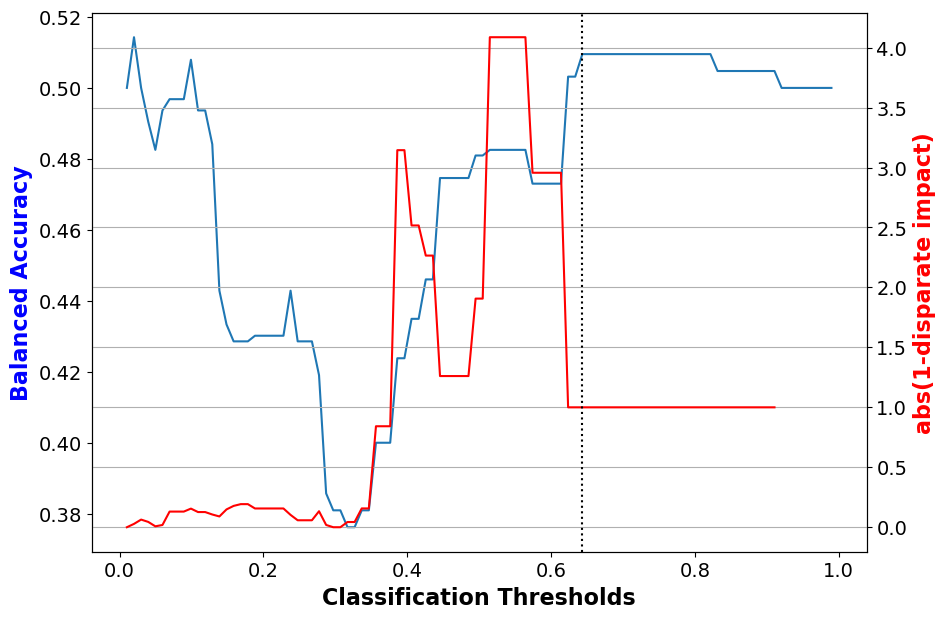

In [27]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

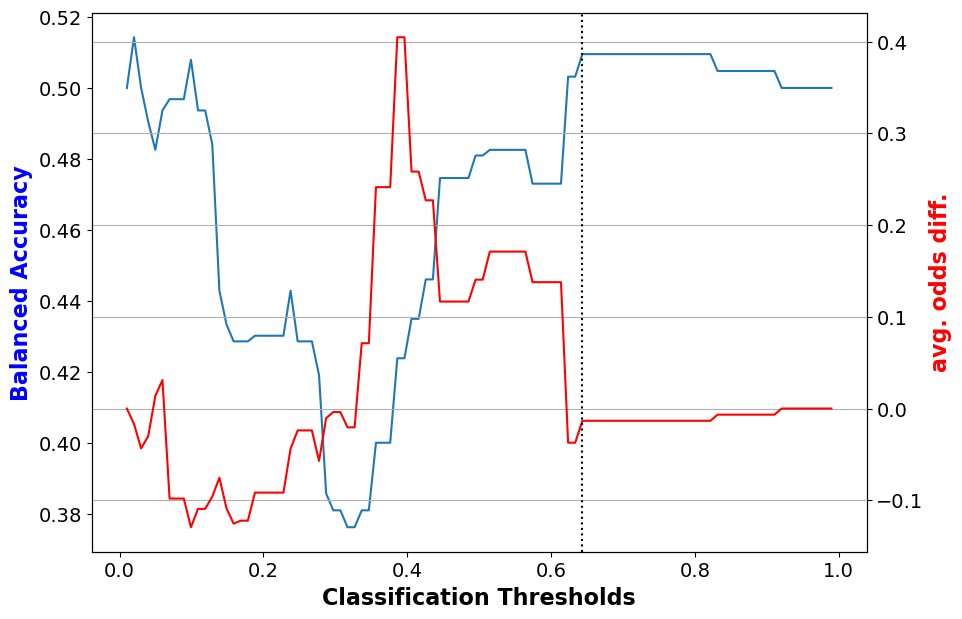

In [28]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

average odds difference = 0.325 ((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

In [18]:
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()
y_train = np.where(y_train == 1, 0, 1)

xgb_unbias = Gbc()
xgb_unbias.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = xgb_unbias.predict(X_train)

# Save the model
xgb_unbias.save_model(os.path.join('..','models','xgboost_credit_unbias_classifier_model.pkl'))

/Users/santinihany/miniconda3/envs/ezkl/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:41:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [19]:
torch_xgb_unbias = convert(xgb_unbias, 'torch')

# Verify the converted model
print(torch_xgb_unbias)

In [20]:
onnx_unbias_path = os.path.join('..','ezkl','credit-unbias','network.onnx')
input_unbias_path = os.path.join('..','ezkl','credit-unbias','input.json')

In [21]:
# Input to the model (you need to define the shape based on your input data)
shape_unbias = X_train.shape[1:]
x_unbias = torch.randint(0, 2, (1, *shape_unbias), dtype=torch.float32, requires_grad=False)

# Export the model to ONNX
torch.onnx.export(torch_xgb_unbias.model,            # model being run
                  x_unbias,                      # model input (or a tuple for multiple inputs)
                  onnx_unbias_path,   # where to save the model (can be a file or file-like object)
                  export_params=True,             # store the trained parameter weights inside the model file
                  opset_version=17,               # the ONNX version to export the model to
                  input_names=['input'],          # the model's input names
                  output_names=['output'],        # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})  # variable length axes


In [22]:
model_path = os.path.join('..','ezkl','credit-unbias','network.onnx')
compiled_model_path = os.path.join('..','ezkl','credit-unbias','network.ezkl')
pk_path = os.path.join('..','ezkl','credit-unbias','pk.key')
vk_path = os.path.join('..','ezkl','credit-unbias','vk.key')
settings_path = os.path.join('..','ezkl','credit-unbias','settings.json')
cal_path = os.path.join('..','ezkl','credit-unbias','calibration.json')
srs_path = os.path.join('..','ezkl','credit-unbias','kzg.srs')

witness_path = os.path.join('..','ezkl','credit-unbias','witness.json')
data_path = os.path.join('..','ezkl','credit-unbias','input.json')
proof_path = os.path.join('..','ezkl','credit-unbias','proof.json')


In [23]:
run_args = ezkl.PyRunArgs()
run_args.variables = [("batch_size", 1)]
run_args.input_visibility = "public"
run_args.output_visibility = "public"

# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

In [25]:
# generate a bunch of dummy calibration data
cal_data = {
    "input_data": [(torch.rand(20, *shape_unbias)).flatten().tolist()],
}

# save as json file
with open(cal_path, "w") as f:
    json.dump(cal_data, f)

res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")



 <------------- Numerical Fidelity Report (input_scale: 12, param_scale: 12, scale_input_multiplier: 10) ------------->

+-------------------+--------------+--------------+---------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error        | median_error | max_error    | min_error     | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+-------------------+--------------+--------------+---------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.000000009934108 | 0            | 0.0001783371 | -0.0001783073 | 0.000118881464 | 0                | 0.0001783371  | 0             | 0.0000000211992    | -0.0006702201      | 0.000799573            |
+-------------------+--------------+--------------+--------------

In [26]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [27]:
# srs path
res = await ezkl.get_srs( settings_path, srs_path=srs_path)

In [29]:
for i in range(20):
        data_path = os.path.join('..','ezkl','credit-bias','inputs',f'input{i+1}.json')
        witness_path = os.path.join('..','ezkl','credit-unbias','witnesses',f'witness{i+1}.json')

        # Generate the witness
        res_witness = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
        assert os.path.isfile(witness_path)

In [30]:

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK



res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path=srs_path
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [31]:
# GENERATE PROOFS
for i in range(20):
    witness_path = os.path.join('..','ezkl','credit-unbias','witnesses',f'witness{i+1}.json')
    proof_path = os.path.join('..','ezkl','credit-unbias','proofs',f'proof{i+1}.json')
    # Generate the proof
    res_proof = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path=srs_path,
        proof_type="single"
    )
    

    assert os.path.isfile(proof_path)
    print(f"Proof for input {i+1} generated successfully.")
    print(res_proof)

Proof for input 1 generated successfully.
{'instances': [['0010000000000000000000000000000000000000000000000000000000000000', '0010000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0010000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0010000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0010000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '8d0b000000000000000000000000000000000000000000000000000000000000', '730400000000000000000000000000000000000000000000000000000

In [32]:
# VERIFY IT
for i in range(20):
    proof_path = os.path.join('..','ezkl','credit-unbias','proofs',f'proof{i+1}.json')
    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
            srs_path=srs_path,
        )

    assert res == True
    print("verified")

verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified


### Create an evm verifier:
```
cd ezkl/credit-unbias/
ezkl create-evm-verifier --srs-path=kzg.srs --vk-path vk.key --sol-code-path verif.sol --settings-path=settings.json
```

In [33]:
# GENERATE ARRAYS FOR TESTING SOLIDIY CONTRACT
hex_proofs = []
combined_inputs_outputs = []

for i in range(20):
    proof_path = os.path.join('..','ezkl','credit-unbias','proofs',f'proof{i+1}.json')

    # Load the proof JSON file
    with open(proof_path, 'r') as f:
        proof_data = json.load(f)

    # Extract the hex_proof attribute
    hex_proof = proof_data["hex_proof"]
    hex_proofs.append(hex_proof)

    # Extract pretty_public_inputs.inputs and outputs
    inputs = proof_data["pretty_public_inputs"]["inputs"][0]
    outputs_0 = proof_data["pretty_public_inputs"]["outputs"][0]
    outputs_1 = proof_data["pretty_public_inputs"]["outputs"][1]

    

    # Combine inputs and outputs into a single array of size (1, 14)
    combined = inputs + outputs_0 + outputs_1
    combined_inputs_outputs.append(combined)

# print("Hex Proofs:")
# print(hex_proofs)
# print("\nCombined Inputs and Outputs:")
# print(combined_inputs_outputs)

# Save the hex_proofs and combined_inputs_outputs to a JSON file
output_data = {
    "hex_proofs": hex_proofs,
    "combined_inputs_outputs": combined_inputs_outputs
}

with open(os.path.join('..','ezkl','credit-unbias','output.json'), 'w') as f:
    json.dump(output_data, f)


In [41]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = xgb_unbias.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [42]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.6435


  0%|          | 0/100 [00:00<?, ?it/s]/Users/santinihany/miniconda3/envs/ezkl/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 2240.44it/s]

Balanced accuracy = 0.5032
Statistical parity difference = -0.0385
Disparate impact = 0.0000
Average odds difference = -0.0372
Equal opportunity difference = -0.0400
Theil index = 1.1471


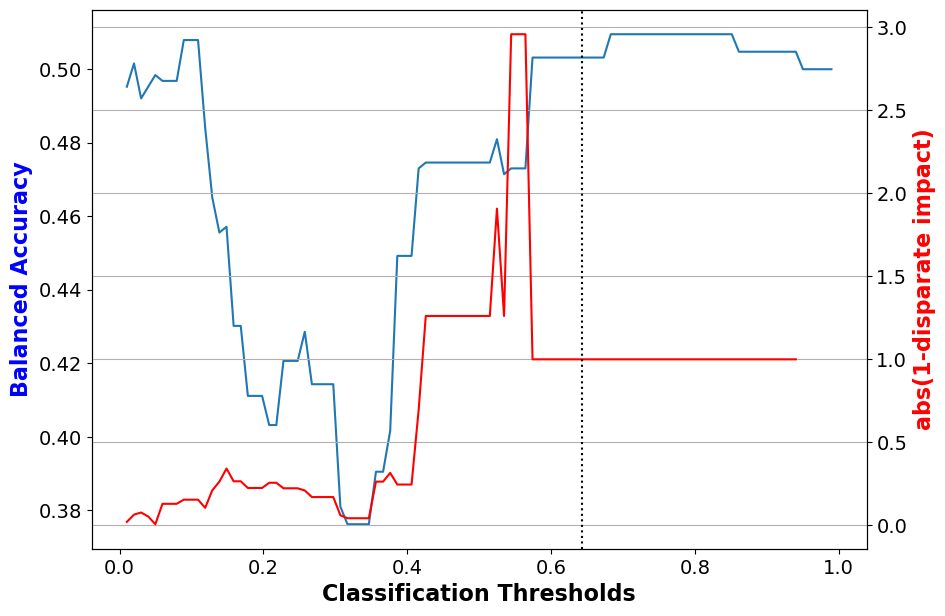

In [43]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.

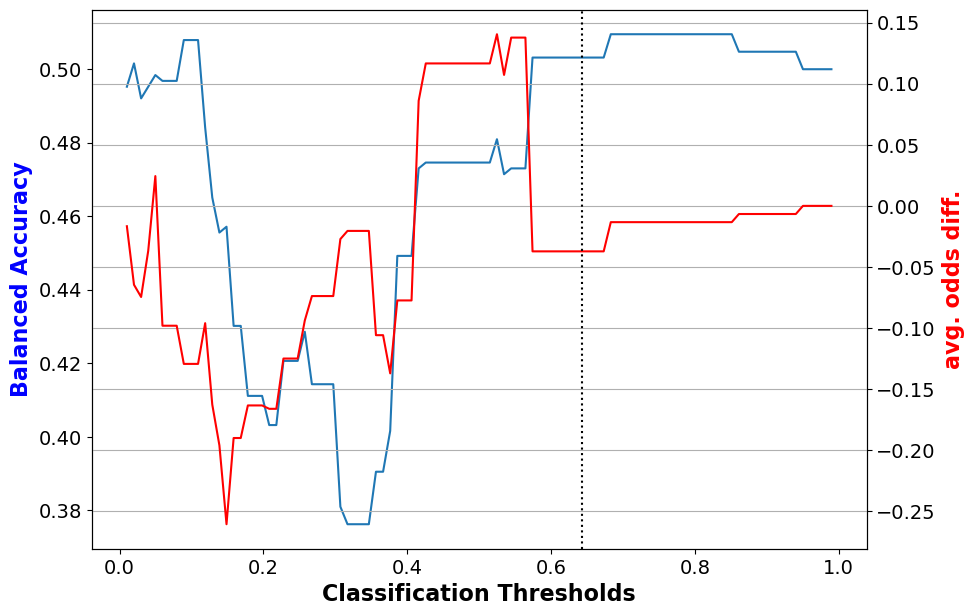

In [44]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

average odds difference = -0.1((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.